In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
# thershold value of 2D KS statistic was taken form Justel1997 paper
# not sure if that is very correct (don't know if aour implementation of 2KS is exacely the same as in the paper)
# this funkction computes approximated tthreshold value for the data (id Dstar=None)
# and computes empirical power of the 2KS
def ks_fix_threshold(df, Dstar=None):
    if not Dstar:
        # determine ciritial value of D statistic from the data
        df_equal = df[(df.true_distrib == df.alter_distrib)]
        ks_fix = []
        for df_row_id in range(df_equal.shape[0]):
            d_values = list(map(float, df_equal.iloc[df_row_id].ks_d.replace('[','').replace(']','').split(',')))
            ks_fix.append(np.quantile(d_values, q=0.95))
        Dstar = np.mean(ks_fix)
    
    ks_fix = []
    #print(f'Empirical critical value of D statistic: {Dstar}')
    for df_row_id in range(df.shape[0]):
            d_values = list(map(float, df.iloc[df_row_id].ks_d.replace('[','').replace(']','').split(',')))
            d_H0 = d_values < Dstar
            d_H0 = np.sum(d_H0)/len(d_H0)
            ks_fix.append(d_H0)
    return ks_fix

In [26]:
def power_matrix(filename, test_label='ks', exclude=[], plot=True):
    
    df = pd.read_csv(filename)
    true_distrib = df.true_distrib.unique()
    alter_distrib = df.alter_distrib.unique()
    values = np.zeros((len(alter_distrib), len(true_distrib)))
    
    ks_fix = ks_fix_threshold(df)
    df['ks_fix'] = ks_fix

    for id_td, td in enumerate(true_distrib):
        for id_ad, ad in enumerate(alter_distrib):
            idx = (df.true_distrib == td) & (df.alter_distrib == ad)
            if np.sum(idx) > 1:
                raise ValueError('Labels are not unique')
            if np.sum(idx) == 1: 
                values[id_ad, id_td] = 1-df.loc[idx][test_label]
                
    # compute average-power
    # exclude diagonal
    for id_td, _ in enumerate(true_distrib):
        values[id_td, id_td] = None
    for id_td, td in enumerate(true_distrib):
        for id_ad, ad in enumerate(alter_distrib):
            if (ad in exclude) or (td in exclude):
                values[id_ad, id_td ] = None
    
    avg_power = np.nanmean(values)
    #print(avg_power)
    
    if plot:
        plt.rcParams['figure.figsize'] = [8, 8]
        fig, ax = plt.subplots(1,1)
        im = ax.imshow(values)
        ax.set_xticks(range(len(true_distrib)))
        ax.set_xticklabels(true_distrib, rotation = 90)
        ax.set_yticks(range(len(alter_distrib)))
        ax.set_yticklabels(alter_distrib)
        ax.set_xlabel('TRUE Distribution')
        ax.set_ylabel('ALTER Distribution')

        ax.set_title(f'POWER of {test_label}-test = {avg_power}')
        fig.colorbar(im)

    return avg_power

In [9]:
def get_results(prefix, N, plot=True):
    filename = f'results.3d/{prefix}_N={N}.csv'
    
    ks_fix = power_matrix(filename, test_label='ks_fix', exclude=[], plot=plot)
    topo_min = power_matrix(filename, test_label='topo_min', exclude=[], plot=plot)
    topo_mean = power_matrix(filename, test_label='topo_mean', exclude=[], plot=plot)
    topo_max = power_matrix(filename, test_label='topo_max', exclude=[], plot=plot)
    
    return N, topo_min, topo_mean, topo_max, ks_fix

In [14]:
def results(prefix='ecc_1_1'):
    Ns = [20, 50, 100, 200]
    Dstar = []

    results = []
    for N in Ns:
        res = get_results(prefix=prefix, N=N, plot=False)
        results.append(res)
    df = pd.DataFrame(results)
    df.columns = ['N', 'topo-min', 'topo-mean', 'topo-max', 'KS']
    return df

In [19]:
df_ecc = results(prefix='ecc_1_1')
df_mg = results(prefix='mergegram_1_1')

# Average test powers

In [20]:
df_ecc

,N,topo-min,topo-mean,topo-max,KS
0,20,0.231259,0.364278,0.400296,0.151444
1,50,0.416389,0.468241,0.471963,0.312444
2,100,0.543148,0.535241,0.432481,0.442333
3,200,0.678130,0.600463,0.508222,0.578000


In [21]:
df_mg

,N,topo-min,topo-mean,topo-max,KS
0,20,0.254389,0.327111,0.316833,0.151444
1,50,0.402778,0.481222,0.553444,0.312444
2,100,0.541500,0.609444,0.732056,0.442333
3,200,0.664278,0.734667,0.806389,0.578000


# Matrix of test powers

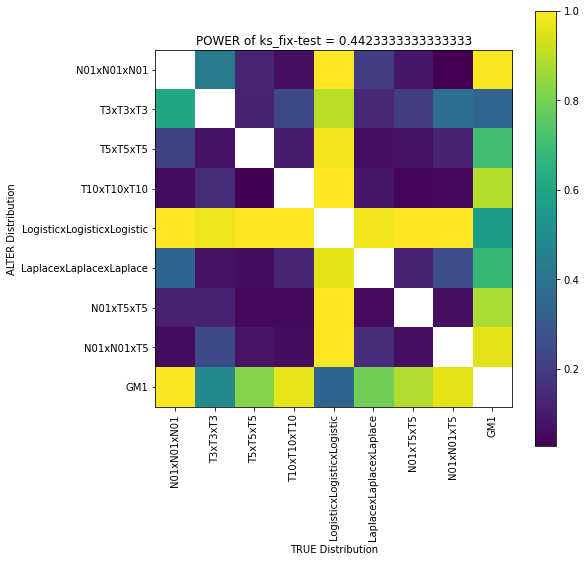

In [30]:
_ = power_matrix('results.3d/ecc_1_1_N=100.csv', test_label='ks_fix')

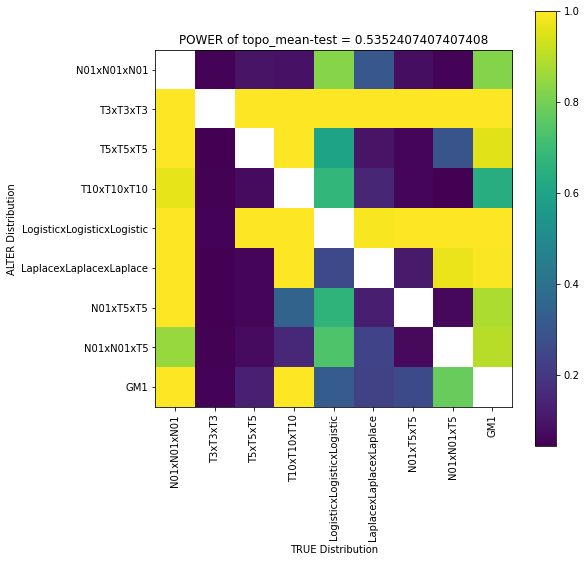

In [31]:
_ = power_matrix('results.3d/ecc_1_1_N=100.csv', test_label='topo_mean')

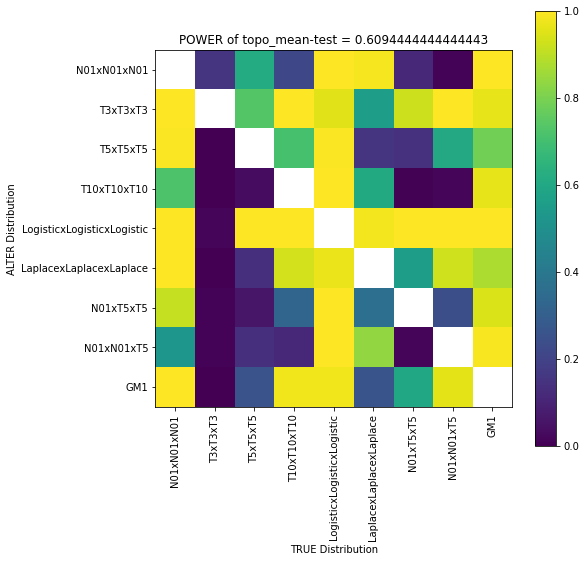

In [33]:
_ = power_matrix('results.3d/mergegram_1_1_N=100.csv', test_label='topo_mean')